In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159    0   159    0     0    282      0 --:--:-- --:--:-- --:--:--   282
100 8863k  100 8863k    0     0  6091k      0  0:00:01  0:00:01 --:--:-- 71.7M


In [ ]:
!unzip /content/captcha_images_v2

Archive:  /content/captcha_images_v2.zip
replace captcha_images_v2/ydd3g.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: captcha_images_v2/ydd3g.png  
 extracting: captcha_images_v2/36nx4.png  
 extracting: captcha_images_v2/3bnyf.png  
 extracting: captcha_images_v2/8y6b3.png  
 extracting: captcha_images_v2/268g2.png  
 extracting: captcha_images_v2/mnef5.png  
 extracting: captcha_images_v2/5p8fm.png  
 extracting: captcha_images_v2/bxxfc.png  
 extracting: captcha_images_v2/8ypdn.png  
 extracting: captcha_images_v2/gpxng.png  
 extracting: captcha_images_v2/e4gd7.png  
 extracting: captcha_images_v2/pbpgc.png  
 extracting: captcha_images_v2/m4g8g.png  
  inflating: captcha_images_v2/c43b4.png  
 extracting: captcha_images_v2/gwnm6.png  
 extracting: captcha_images_v2/w4x2m.png  
 extracting: captcha_images_v2/npxb7.png  
 extracting: captcha_images_v2/445cc.png  
 extracting: captcha_images_v2/pg2pm.png  
 extracting: captcha_images_v2/wc2bd.png  
 extracting: captcha_i

In [ ]:
data_dir = Path("/content/captcha_images_v2")

images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)


batch_size = 16


img_width = 200
img_height = 200
downsample_factor = 4


max_length = max([len(label) for label in labels])

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'5', 'f', 'p', '3', 'n', '4', '2', '6', 'e', 'm', 'x', 'b', 'w', '8', 'd', 'g', 'c', 'y', '7'}


In [ ]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):

    size = len(images)
   
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

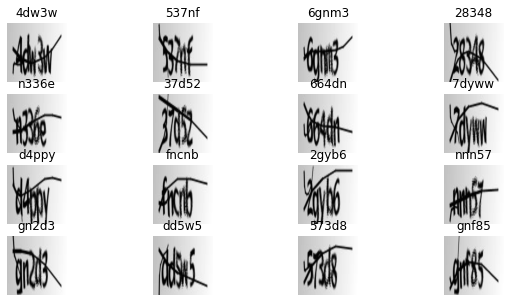

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        .
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

  
        return y_pred


def build_model():

    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)


    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)


    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

   
    output = CTCLayer(name="ctc_loss")(labels, x)

   
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="CRNN"
    )

    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt)
    return model


# model
model = build_model()
model.summary()

Model: "CRNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 200, 32) 320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 100, 32) 0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 100, 64) 18496       pool1[0][0]                      
_______________________________________________________________________________________________

In [ ]:
epochs = 100
early_stopping_patience = 10

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)


history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/100
59/59 [==============================] - 62s 930ms/step - loss: 30.3177 - val_loss: 16.3486
Epoch 2/100
59/59 [==============================] - 55s 931ms/step - loss: 16.3311 - val_loss: 16.3772
Epoch 3/100
59/59 [==============================] - 54s 908ms/step - loss: 16.3329 - val_loss: 16.3896
Epoch 4/100
59/59 [==============================] - 53s 905ms/step - loss: 16.3266 - val_loss: 16.4015
Epoch 5/100
59/59 [==============================] - 54s 905ms/step - loss: 16.3240 - val_loss: 16.3878
Epoch 6/100
59/59 [==============================] - 54s 906ms/step - loss: 16.3113 - val_loss: 16.3980
Epoch 7/100
59/59 [==============================] - 54s 910ms/step - loss: 16.3156 - val_loss: 16.3695
Epoch 8/100
59/59 [==============================] - 54s 907ms/step - loss: 16.3093 - val_loss: 16.3539
Epoch 9/100
59/59 [==============================] - 54s 908ms/step - loss: 16.2719 - val_loss: 16.3812
Epoch 10/100
59/59 [==============================] - 53s 904ms/

In [ ]:

print(history.history.keys())

dict_keys(['loss', 'val_loss'])


In [ ]:
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored